In [1]:
from tensorflow.python.keras.applications import DenseNet121
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.python.keras.models import Model
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy

# basic module
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil
import glob
import time
import pickle

plt.style.use('seaborn-dark')
%config InlineBackend.figure_format = 'retina'
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20

plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = False


# image module
import cv2
from pydicom import dcmread
import pylibjpeg
from PIL import Image
import pydicom as dcm
from pydicom import dcmread
from pydicom.data import get_testdata_file



# dataset
df = pd.read_csv('dataset.csv',index_col=0)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [10]:
#메모리확인

import psutil
import os

print("=="*20)
print("== memory usage check")

for exec_num in range(0, 2):
    # BEFORE code
    print(f"== {exec_num:2d} exec")
    # general RAM usage
    memory_usage_dict = dict(psutil.virtual_memory()._asdict())
    memory_usage_percent = memory_usage_dict['percent']
    print(f"BEFORE CODE: memory_usage_percent: {memory_usage_percent}%")
    # current process RAM usage
    pid = os.getpid()
    current_process = psutil.Process(pid)
    current_process_memory_usage_as_KB = current_process.memory_info()[0] / 2.**20
    print(f"BEFORE CODE: Current memory KB   : {current_process_memory_usage_as_KB: 9.3f} KB")

    X = [i for i in range(0, 9000000)]
    # AFTER  code
    memory_usage_dict = dict(psutil.virtual_memory()._asdict())
    memory_usage_percent = memory_usage_dict['percent']
    print(f"AFTER  CODE: memory_usage_percent: {memory_usage_percent}%")
    # current process RAM usage
    pid = os.getpid()
    current_process = psutil.Process(pid)
    current_process_memory_usage_as_KB = current_process.memory_info()[0] / 2.**20
    print(f"AFTER  CODE: Current memory KB   : {current_process_memory_usage_as_KB: 9.3f} KB")
    del X
    print("--"*30)

== memory usage check
==  0 exec
BEFORE CODE: memory_usage_percent: 51.2%
BEFORE CODE: Current memory KB   :  9807.055 KB
AFTER  CODE: memory_usage_percent: 30.0%
AFTER  CODE: Current memory KB   :  5560.926 KB
------------------------------------------------------------
==  1 exec
BEFORE CODE: memory_usage_percent: 28.2%
BEFORE CODE: Current memory KB   :  5213.305 KB
AFTER  CODE: memory_usage_percent: 30.0%
AFTER  CODE: Current memory KB   :  5560.820 KB
------------------------------------------------------------


In [4]:
from tensorflow.python.keras.layers import BatchNormalization

backbone = DenseNet121(include_top=False, weights=None, input_shape=(224, 224, 3))
backbone_out = backbone.output
backbone_out = BatchNormalization()(backbone_out)
gap = GlobalAveragePooling2D(name='pooling_layer')(backbone_out)
output = Dense(units=7, activation='sigmoid', name='output_layer')(gap)
chexnet_model = Model(inputs=backbone.input, outputs=output)

In [ ]:
chexnet_model.summary()

In [6]:
data = pd.read_csv('/home/ncp/workspace/data/dataset_.csv',index_col=0)

dcm_list = list(data['orginal_dcm_file'])
mask_path_list = list(data['body_part_file'])
img_path_list = []

for i in dcm_list:
    png_img = i.replace('.dcm','.png')
    img_path_list.append(png_img)

def normal_dia(x):
    if x == 9:
        return 0
    else:
        return x
    
    
data['diagnosis'] = data['diagnosis'].apply(normal_dia)

In [7]:
crop_list = list(data['crop_file'])

import numpy as np
import cv2

def cvt_crop(og_img_path, size):
    
    og_img = cv2.imread(og_img_path)
    
    
    # clahe
    clahe = cv2.createCLAHE(5.0,(8,8))
    
    ## og_img_convert
    cvt_img = cv2.resize(og_img, size)
    cvt_img = cv2.cvtColor(cvt_img,cv2.COLOR_BGR2GRAY)
    cvt_img = clahe.apply(cvt_img)  # 1 channel
    cvt_img = np.repeat(cvt_img[:,:,np.newaxis],3,-1)

    return cvt_img



def rv_3ch(og_img_path, mask_path, size):
    
    #module import
    import cv2
    
    # im_read
    og_img = cv2.imread(og_img_path)
    mask = cv2.imread(mask_path)
    
    # clahe
    clahe = cv2.createCLAHE(5.0,(12,12))
    
    ## og_img_convert
    cvt_img = cv2.resize(og_img, size)
    cvt_img = cv2.cvtColor(cvt_img,cv2.COLOR_BGR2GRAY)
    cvt_img = clahe.apply(cvt_img)  # 1 channel
    cvt_img = np.repeat(cvt_img[:,:,np.newaxis],3,-1)

    ## mask
    cvt_mask = cv2.resize(mask, size)
    cvt_mask = cv2.cvtColor(cvt_mask, cv2.COLOR_BGR2GRAY)

    ## remove
    remove = cv2.bitwise_and(cvt_img, cvt_img, mask = cvt_mask)
    
    return remove
#     print(remove.shape)
#     plt.imshow(remove)

In [12]:
X = np.ndarray((4000,224,224,3))

for i in range(len(X)):
#     X[i][:][:][:] = rv_3ch(img_path_list[i], mask_path_list[i], (224,224))
      X[i][:][:][:] = cvt_crop(crop_list[i], (224,224)).astype(np.uint8)
    
y = np.array(data['diagnosis'])

In [13]:
from sklearn.model_selection import train_test_split

Xtr, Xva, Ytr, Yva = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
Xva, Xtst, Yva, Ytst = train_test_split(Xva,Yva, test_size=0.5, random_state=42, stratify=Yva)

In [14]:
from tensorflow.python.keras.utils import to_categorical

Ytr_c = to_categorical(Ytr)
Yva_c = to_categorical(Yva)
Ytst_c = to_categorical(Ytst)

In [15]:
print(Xtr.shape ,'/', Ytr.shape ,'/', Ytr_c.shape)
print(Xva.shape ,'/', Yva.shape ,'/', Yva_c.shape)
print(Xtst.shape ,'/', Ytst.shape ,'/', Ytst_c.shape)

(3200, 224, 224, 3) / (3200,) / (3200, 7)
(400, 224, 224, 3) / (400,) / (400, 7)
(400, 224, 224, 3) / (400,) / (400, 7)


In [16]:
# 이미지 증식

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


data_gen_args = dict(horizontal_flip=True, vertical_flip = True, rotation_range = 10)
image_datagen = ImageDataGenerator(**data_gen_args)

seed = 1

train_generator = image_datagen.flow(x=Xtr, y=Ytr_c,
                                    batch_size=3,
                                    shuffle=True)
validation_generator = image_datagen.flow(x=Xva, y=Yva_c,
                                         batch_size=3,
                                         shuffle=True)
# test_generator = image_datagen.flow(x=Xtst, y=Ytst_c,
#                                          batch_size=16,
#                                          shuffle=True)

In [17]:
from tensorflow.python.keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision

def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

class_weight = {0:0.571428563,
                1:1.397990367,
                2:4.617604545,
                3:1.662337636,
                4:0.892857129,
                5:0.571428563,
                6:1.181247674}

 
# class_weights = class_weight.compute_class_weight(
#                 'balanced',
#                  np.unique(train_generator.classes), 
#                  train_generator.classes)

chexnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1score])
del X

In [19]:
# chexnet_model.compile(optimizer='nadam', loss='binary_crossentropy',metrics=['acc'])
import tensorflow as tf

# history = chexnet_model.fit(Xtr,Ytr_c, validation_data=[Xva,Yva_c],batch_size=32, epochs=20)
history2 = chexnet_model.fit_generator(train_generator, validation_data=validation_generator, epochs=150,
                                       steps_per_epoch=40,
                                       class_weight = class_weight)

Epoch 1/150
200/200 [==============================] - 183s 914ms/step - loss: 0.4478 - acc: 0.8054 - precision: 0.2906 - recall: 0.1359 - f1score: 0.1268 - val_loss: 0.6179 - val_acc: 0.8304 - val_precision: 0.2901 - val_recall: 0.1350 - val_f1score: 0.1815
Epoch 2/150
200/200 [==============================] - 65s 325ms/step - loss: 0.3655 - acc: 0.8563 - precision: 0.4390 - recall: 0.0772 - f1score: 0.1262 - val_loss: 0.8354 - val_acc: 0.7171 - val_precision: 0.1935 - val_recall: 0.3050 - val_f1score: 0.2365
Epoch 3/150
200/200 [==============================] - 66s 330ms/step - loss: 0.3455 - acc: 0.8613 - precision: 0.5763 - recall: 0.1200 - f1score: 0.1915 - val_loss: 2.2757 - val_acc: 0.7421 - val_precision: 0.1016 - val_recall: 0.1025 - val_f1score: 0.1020
Epoch 4/150
200/200 [==============================] - 66s 330ms/step - loss: 0.3407 - acc: 0.8616 - precision: 0.5753 - recall: 0.1369 - f1score: 0.2135 - val_loss: 1.5344 - val_acc: 0.7436 - val_precision: 0.1025 - val_reca

In [24]:
pred = chexnet_model.predict(Xtst)

In [27]:
pred[0]

array([1.16368264e-01, 4.37421858e-01, 5.13404608e-04, 1.29103661e-04,
       4.77754116e-01, 1.14682287e-01, 1.48415565e-05], dtype=float32)

In [28]:
from tensorflow.python.keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [20]:
_loss, _acc, _precision, _recall, _f1score = chexnet_model.evaluate(Xtst, Ytst_c, batch_size=32, verbose=1)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _precision, _recall, _f1score))

400/400 [==============================] - 3s 7ms/sample - loss: 0.6005 - acc: 0.8671 - precision: 0.5380 - recall: 0.4832 - f1score: 0.5076
loss: 0.600, accuracy: 0.867, precision: 0.538, recall: 0.483, f1score: 0.508


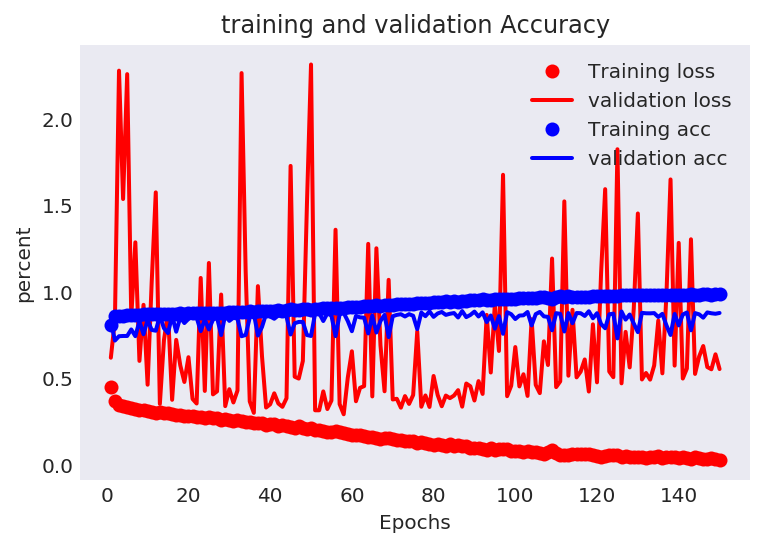

In [21]:
import matplotlib.pyplot as plt
loss = history2.history['loss']
val_loss = history2.history['val_loss']
plt.clf()

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label = 'Training loss', color='red')
plt.plot(epochs, val_loss, 'b', label = 'validation loss', color='red')
plt.title('training and validation loss')


acc= history2.history['acc']
val_acc = history2.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'validation acc')
plt.title('training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('percent')
plt.legend()
plt.show()

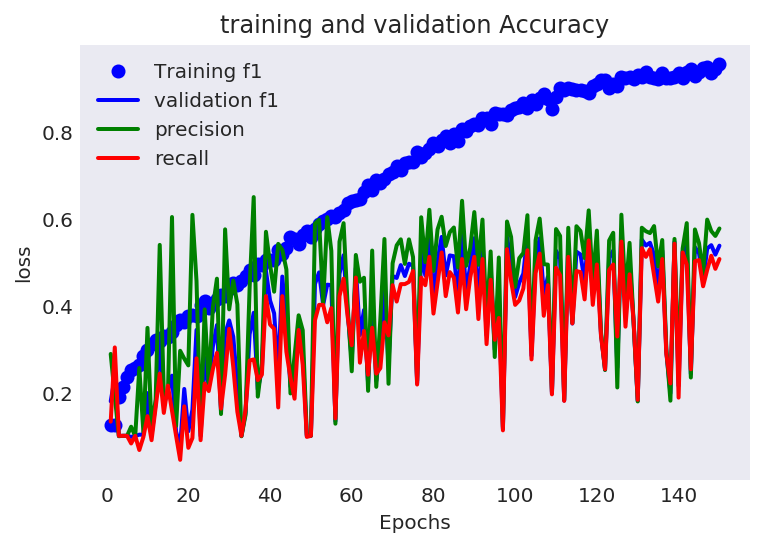

In [22]:
plt.clf()
f1= history2.history['f1score']
val_f1 = history2.history['val_f1score']
val_pre= history2.history['val_precision']
val_recall = history2.history['val_recall']
plt.plot(epochs, f1, 'bo', label='Training f1')
plt.plot(epochs, val_f1, 'b', label = 'validation f1')
plt.plot(epochs, val_pre, 'b', label='precision' , color='green')
plt.plot(epochs, val_recall, 'b', label = 'recall', color='red')

plt.title('training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
pred = chexnet_model.predict(Xtst)

In [34]:
print(pred.shape)
print(Ytst_c.shape)

(400, 7)
(400, 7)


In [81]:
Ytst_c[0]

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [24]:
pred[0]

array([2.4706125e-03, 3.8710535e-03, 0.0000000e+00, 4.5409799e-04,
       7.7241778e-01, 1.5062064e-02, 0.0000000e+00], dtype=float32)

In [82]:
from tensorflow.python.keras import metrics

metrics.binary_accuracy(Ytst_c, pred, threshold=0.5)

<tf.Tensor 'Mean_4:0' shape=(400,) dtype=float32>

In [33]:
chexnet_model.evaluate(Xtst, Ytst_c, batch_size=16)

400/400 [==============================] - 2s 6ms/sample - loss: 0.3959 - acc: 0.8479 - precision: 0.4446 - recall: 0.2725 - f1score: 0.3344


[0.3959042978286743, 0.8478573, 0.44460198, 0.2725, 0.33439186]

In [25]:
ytst_a = np.asarray(Ytst_c).argmax(axis=1)
pred_a = np.asarray(pred).argmax(axis=1)

In [26]:
pred_a

array([4, 5, 4, 6, 4, 2, 5, 1, 6, 2, 0, 0, 5, 1, 4, 1, 0, 5, 0, 4, 5, 6,
       5, 4, 6, 1, 0, 4, 5, 6, 4, 0, 6, 6, 4, 6, 0, 4, 0, 0, 4, 5, 5, 6,
       0, 4, 5, 1, 5, 4, 0, 5, 5, 5, 4, 6, 4, 0, 1, 0, 1, 4, 0, 1, 0, 5,
       0, 5, 0, 0, 5, 1, 6, 1, 0, 0, 5, 1, 0, 0, 4, 5, 4, 4, 6, 5, 0, 0,
       1, 5, 0, 1, 1, 6, 4, 4, 1, 1, 0, 4, 1, 4, 0, 4, 4, 4, 4, 0, 1, 6,
       4, 4, 0, 3, 5, 0, 0, 0, 1, 6, 4, 2, 1, 0, 0, 6, 4, 5, 0, 0, 0, 6,
       0, 6, 4, 5, 0, 5, 5, 0, 5, 6, 4, 0, 5, 4, 1, 1, 0, 0, 0, 5, 0, 0,
       1, 5, 4, 4, 4, 0, 4, 6, 0, 5, 0, 1, 6, 5, 1, 5, 4, 5, 4, 1, 5, 1,
       0, 0, 1, 5, 5, 1, 5, 4, 6, 0, 4, 5, 4, 4, 5, 0, 4, 0, 0, 1, 1, 6,
       6, 0, 6, 5, 5, 0, 6, 0, 6, 4, 4, 0, 1, 0, 1, 6, 0, 0, 4, 0, 0, 4,
       0, 0, 6, 5, 0, 1, 5, 4, 4, 1, 5, 0, 6, 1, 6, 1, 1, 6, 4, 5, 2, 1,
       6, 0, 4, 0, 5, 3, 0, 0, 0, 0, 6, 0, 1, 0, 6, 4, 4, 5, 6, 3, 4, 5,
       5, 5, 4, 1, 6, 5, 4, 4, 5, 1, 4, 5, 0, 4, 4, 6, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 5, 0, 0, 6, 0, 0, 1, 4, 0, 4, 5, 4,

In [37]:
from sklearn.metrics import f1_score

f1_score(ytst_a, pred_a, average='macro')

0.3296415786086375

In [38]:
from sklearn.metrics import accuracy_score

accuracy_score(ytst_a, pred_a)

0.38

In [39]:
from sklearn.metrics import confusion_matrix

predictions_one_hot = chexnet_model.predict(Xtst)
cm = confusion_matrix(Ytst_c.argmax(axis=1), predictions_one_hot.argmax(axis=1))
print(cm)

[[52 35  7  0  5  1  0]
 [ 6 29  1  0  4  0  1]
 [ 3  3  4  0  1  2  0]
 [13 10  5  3  1  1  1]
 [ 2 15  0  0 47  0  0]
 [41 39  6  2  7  2  3]
 [ 5 17  5  2  3  1 15]]


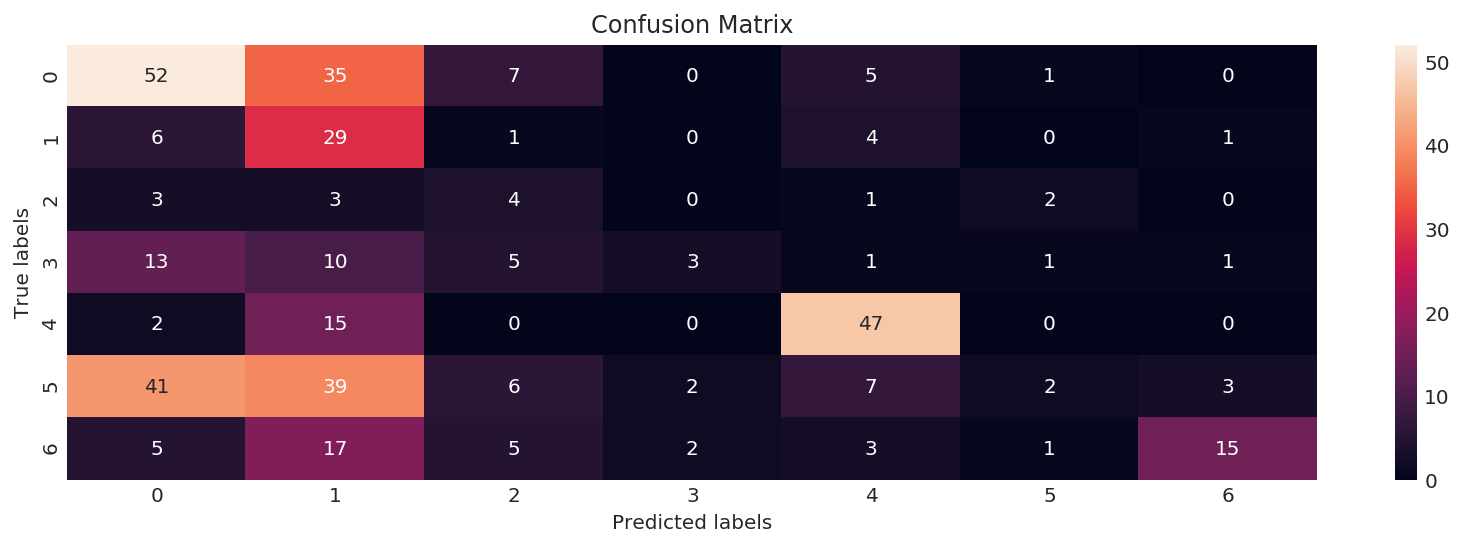

<Figure size 1080x720 with 0 Axes>

In [40]:
import seaborn as sns


T5_lables = ['0','1','2','3','4','5','6']    

ax= plt.subplot()

plt.figure(figsize=(15,10))
cm = confusion_matrix(np.asarray(Ytst_c).argmax(axis=1), np.asarray(pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);
